Exercise 1: Demonstrates molecular dynamics with constant energy.

In [24]:
!pip install ase
from ase import units
from ase.build import bulk, make_supercell
from ase.calculators.emt import EMT
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase.md.verlet import VelocityVerlet
from ase.io.trajectory import Trajectory
from ase.optimize.bfgs import BFGS
from ase.constraints import StrainFilter
import numpy as np
from ase.visualize import view

Set up a crystal

In [2]:
element_symbol = 'Cu'
atoms = bulk(element_symbol, 'fcc', a=3.597)

Describe the interatomic interactions with the Effective Medium Theory

In [3]:
atoms.calc = EMT()

Before we run the molecular dynamics, let's first optimize the unit cell

In [4]:
constraints = StrainFilter(atoms)

<ipython-input-4-d290ae88053f>:1: FutureWarning: Import StrainFilter from ase.filters
  constraints = StrainFilter(atoms)


In [5]:
trajectory_filename = f'{element_symbol}_opt.traj'
logfile_filename = f'{element_symbol}_opt.log'

In [6]:
opt = BFGS(constraints, trajectory=trajectory_filename, logfile=logfile_filename)
opt.run(fmax=0.01)

True

Let's view the atoms

In [46]:
view(atoms, viewer='x3d')

After optimization, access the optimized lattice constant 'a'

In [8]:
optimized_a = atoms.get_cell_lengths_and_angles()[0] * (2 ** 0.5)  # For a cubic cell, the first value represents 'a'

<ipython-input-8-6e5cb740ac85>:1: DeprecationWarning: Please use atoms.cell.cellpar() instead
  optimized_a = atoms.get_cell_lengths_and_angles()[0] * (2 ** 0.5)  # For a cubic cell, the first value represents 'a'


In [9]:
print(f"The optimized lattice constant 'a' is: {optimized_a} Å")

The optimized lattice constant 'a' is: 3.5897932338617675 Å


Calculate the volume of the unit cell for FCC

In [10]:
volume_unit_cell = optimized_a ** 3

For FCC, there are 4 atoms per unit cell

In [11]:
num_atoms_unit_cell = 4

FCC packing density calculation

In [12]:
radius = optimized_a / (2 * (2 ** 0.5))  # Radius of the atoms in an FCC lattice

Calculate the volume of one sphere in the unit cell

In [13]:
volume_one_sphere = (4 / 3) * np.pi * (radius ** 3)

Calculate the packing density

In [14]:
packing_density = ((num_atoms_unit_cell * volume_one_sphere) / volume_unit_cell) * 100

In [15]:
print(f"The packing efficiency of the optimized FCC unit cell is: {packing_density:.4f}%")

The packing efficiency of the optimized FCC unit cell is: 74.0480%


Now, let's create a supercell for molecular dynamics

In [16]:
supercell_size = [[5, 0, 0], [0, 5, 0], [0, 0, 5]]  # Define the size of the supercell (5x5x5)
supercell = make_supercell(atoms, supercell_size)

Let's view the supercell

In [47]:
view(atoms, viewer='x3d')

In [18]:
supercell.calc = EMT()

Set the momenta corresponding to T=300K

In [30]:
MaxwellBoltzmannDistribution(supercell, temperature_K=300)

In [31]:
md_logfile = f'{element_symbol}_md.log'

Run MD with constant energy using the VelocityVerlet algorithm.

In [32]:
dyn = VelocityVerlet(supercell, 5 * units.fs, logfile=md_logfile)  # 5 fs time step.

In [33]:
def printenergy(a=supercell):
    """Function to print the potential, kinetic, and total energy."""
    epot = a.get_potential_energy() / len(a)
    ekin = a.get_kinetic_energy() / len(a)
    print('Energy per atom: Epot = %.3feV  Ekin = %.3feV (T=%3.0fK)  '
          'Etot = %.3feV' % (epot, ekin, ekin / (1.5 * units.kB), epot + ekin))

Run the dynamics

In [34]:
dyn.attach(printenergy, interval=10)

In [35]:
trajectory_filename = f'{element_symbol}_md.traj'

In [36]:
traj = Trajectory(trajectory_filename, 'w', supercell)
dyn.attach(traj.write, interval=10)

In [37]:
printenergy()
dyn.run(200)

Energy per atom: Epot = -0.007eV  Ekin = 0.040eV (T=311K)  Etot = 0.033eV
Energy per atom: Epot = -0.007eV  Ekin = 0.040eV (T=311K)  Etot = 0.033eV
Energy per atom: Epot = 0.022eV  Ekin = 0.012eV (T= 90K)  Etot = 0.033eV
Energy per atom: Epot = 0.016eV  Ekin = 0.018eV (T=136K)  Etot = 0.033eV
Energy per atom: Epot = 0.013eV  Ekin = 0.020eV (T=155K)  Etot = 0.033eV
Energy per atom: Epot = 0.010eV  Ekin = 0.023eV (T=181K)  Etot = 0.033eV
Energy per atom: Epot = 0.011eV  Ekin = 0.022eV (T=172K)  Etot = 0.033eV
Energy per atom: Epot = 0.014eV  Ekin = 0.019eV (T=148K)  Etot = 0.033eV
Energy per atom: Epot = 0.015eV  Ekin = 0.019eV (T=145K)  Etot = 0.033eV
Energy per atom: Epot = 0.013eV  Ekin = 0.020eV (T=157K)  Etot = 0.033eV
Energy per atom: Epot = 0.011eV  Ekin = 0.022eV (T=172K)  Etot = 0.033eV
Energy per atom: Epot = 0.012eV  Ekin = 0.021eV (T=164K)  Etot = 0.033eV
Energy per atom: Epot = 0.013eV  Ekin = 0.021eV (T=159K)  Etot = 0.033eV
Energy per atom: Epot = 0.015eV  Ekin = 0.018eV (

True

In [48]:
import pandas as pd
import matplotlib.pyplot as plt

In [49]:
data = pd.read_csv("Cu_md.log", sep='\s+', skiprows=1)
data.columns = ['Time[ps]', 'Etot[eV]', 'Epot[eV]', 'Ekin[eV]', 'T[K]']

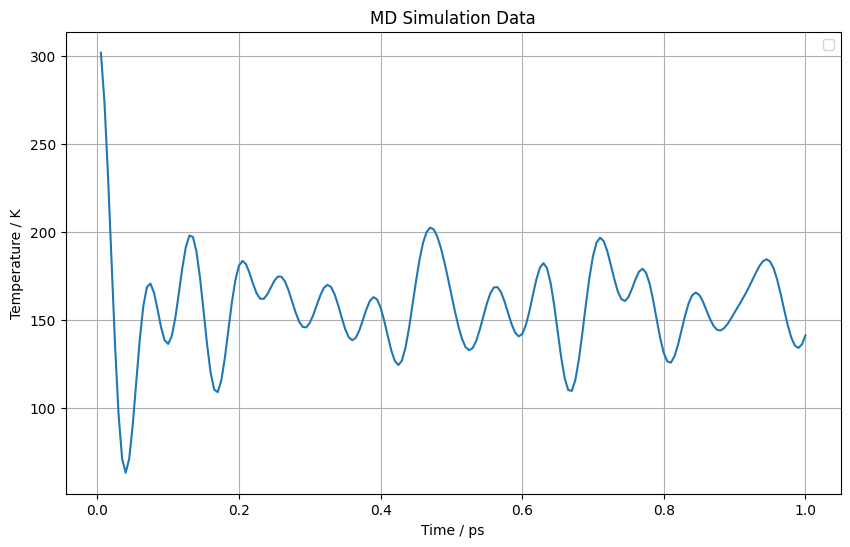

In [50]:
plt.figure(figsize=(10, 6))
plt.plot(data['Time[ps]'], data['T[K]'])
plt.xlabel('Time / ps')
plt.ylabel('Temperature / K')
plt.title('MD Simulation Data')
plt.legend()
plt.grid(True)
plt.show()

In [51]:
from ase.io import Trajectory
import pandas as pd
import numpy as np
import matplotlib.cm as cm
from scipy.ndimage.filters import gaussian_filter
import matplotlib.pyplot as plt

<ipython-input-51-f058ba7c36bb>:5: DeprecationWarning: Please import `gaussian_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter


In [52]:
traj = Trajectory('Cu_md.traj') #Input your MD file here

In [53]:
bond1 = []
for atoms in traj[0:200]:
    dist1 = atoms.get_distance(0,1)
    bond1.append(dist1)
bond2 = []
for atoms in traj[0:200]:
    dist2 = atoms.get_distance(1,2)
    bond2.append(dist2)

In [54]:
data = pd.read_csv("Cu_md.log", sep='\s{2,}',header=None, nrows=200, skiprows=[0])
data = pd.DataFrame(data)

<ipython-input-54-3b6985f537d3>:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  data = pd.read_csv("Cu_md.log", sep='\s{2,}',header=None, nrows=200, skiprows=[0])


In [55]:
z = data[1].tolist()
x = bond1
y = bond2

In [56]:
df = pd.DataFrame(list(zip(x,y,z)), columns=list('XYZ'))
print(df)

           X         Y      Z
0   2.538367  2.538367  4.153
1   2.598524  2.530614  4.154
2   2.586518  2.529633  4.158
3   2.591797  2.548226  4.165
4   2.466024  2.570190  4.173
5   2.464658  2.512491  4.181
6   2.635521  2.522998  4.187
7   2.666357  2.546602  4.190
8   2.492679  2.489860  4.188
9   2.420190  2.509844  4.184
10  2.575360  2.504393  4.178
11  2.668776  2.568235  4.171
12  2.616965  2.628278  4.167
13  2.398307  2.546402  4.164
14  2.530137  2.447147  4.164
15  2.685412  2.554446  4.165
16  2.580521  2.557629  4.168
17  2.466441  2.521374  4.172
18  2.444312  2.543511  4.175
19  2.544787  2.481592  4.178
20  2.634110  2.498140  4.179


Text(0.5, 0, 'Cu1-Cu2/ Å')

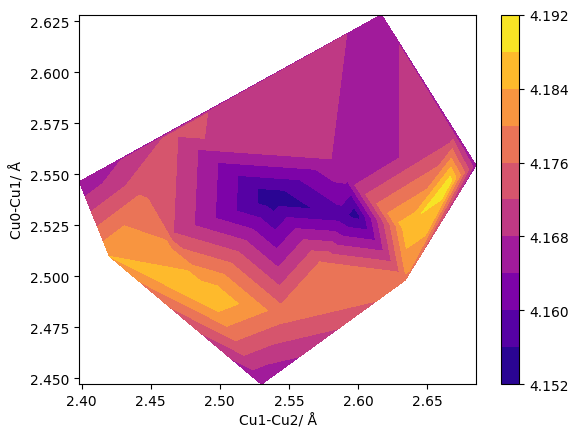

In [57]:
plt.tricontourf(df["X"], df["Y"], df["Z"],levels=10, cmap='plasma')
plt.colorbar()
plt.ylabel('Cu0-Cu1/ Å')
plt.xlabel('Cu1-Cu2/ Å')

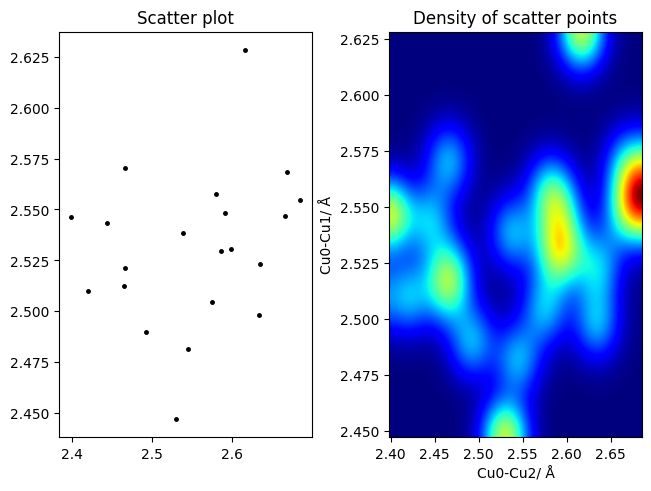

In [58]:
def myplot(x, y, s, bins=1000):
    heatmap, xedges, yedges = np.histogram2d(x, y, bins=bins)
    heatmap = gaussian_filter(heatmap, sigma=s)
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    return heatmap.T, extent
fig, axs = plt.subplots(1, 2, constrained_layout=True)
sigmas = [0, 64]
for ax, s in zip(axs.flatten(), sigmas):
    if s == 0:
        ax.plot(df['X'], df['Y'], 'k.', markersize=5)
        ax.set_title("Scatter plot")
    else:
        img, extent = myplot(df['X'], df['Y'], s)
        ax.imshow(img, aspect="auto", extent=extent, origin='lower', cmap=cm.jet)
        ax.set_title("Density of scatter points")
plt.ylabel('Cu0-Cu1/ Å')
plt.xlabel('Cu0-Cu2/ Å')
plt.show()